# ProZorro Dataset - Exploratory Data Analysis

**Мета:** Аналіз 13M+ тендерів ProZorro для виявлення аномалій та підозрілих патернів

**Структура аналізу:**
1. Завантаження та огляд даних
2. Temporal Analysis (динаміка по часу)
3. Geographic Analysis (регіональний розподіл)
4. Competition Analysis (конкурентність)
5. Price Analysis (цінові аномалії)
6. Fraud Indicators (індикатори шахрайства)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
pd.set_option('display.max_columns', 50)
pd.set_option('display.float_format', '{:.2f}'.format)

DATA_DIR = Path('../data')
print(f'Data directory: {DATA_DIR.resolve()}')

## 1. Завантаження даних

In [2]:
# Load all tenders
tenders_list = []
for year in [2022, 2023, 2024, 2025]:
    file = DATA_DIR / f'tenders_{year}.csv'
    if file.exists():
        df = pd.read_csv(file, low_memory=False)
        print(f'tenders_{year}: {len(df):,} records')
        tenders_list.append(df)

tenders = pd.concat(tenders_list, ignore_index=True)
print(f'\nTotal tenders: {len(tenders):,}')

tenders_2022: 2,401,937 records
tenders_2023: 3,599,565 records
tenders_2024: 3,437,381 records
tenders_2025: 3,657,528 records

Total tenders: 13,096,411


In [3]:
# Load reference tables
buyers = pd.read_csv(DATA_DIR / 'buyers.csv')
suppliers = pd.read_csv(DATA_DIR / 'suppliers.csv')
bidders = pd.read_csv(DATA_DIR / 'bidders.csv')

print(f'Buyers: {len(buyers):,}')
print(f'Suppliers: {len(suppliers):,}')
print(f'Bidders: {len(bidders):,}')

Buyers: 36,004
Suppliers: 358,983
Bidders: 2,629,571


In [4]:
# Convert dates
tenders['published_date'] = pd.to_datetime(tenders['published_date'], errors='coerce', utc=True)
tenders['award_date'] = pd.to_datetime(tenders['award_date'], errors='coerce', utc=True)

# Basic info
print('Columns:', len(tenders.columns))
print('\nDate range:')
print(f"  From: {tenders['published_date'].min()}")
print(f"  To: {tenders['published_date'].max()}")

Columns: 55

Date range:
  From: 2022-01-01 08:19:47.673748+00:00
  To: 2025-12-31 21:57:22.802807+00:00


In [5]:
# Overview
tenders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13096411 entries, 0 to 13096410
Data columns (total 55 columns):
 #   Column                     Dtype              
---  ------                     -----              
 0   tender_id                  object             
 1   ocid                       object             
 2   published_date             datetime64[ns, UTC]
 3   tender_start_date          object             
 4   tender_end_date            object             
 5   award_period_start         object             
 6   award_period_end           object             
 7   award_date                 datetime64[ns, UTC]
 8   year                       int64              
 9   month                      int64              
 10  quarter                    int64              
 11  day_of_week                int64              
 12  is_q4                      int64              
 13  is_december                int64              
 14  is_weekend                 int64              
 

## 2. Temporal Analysis

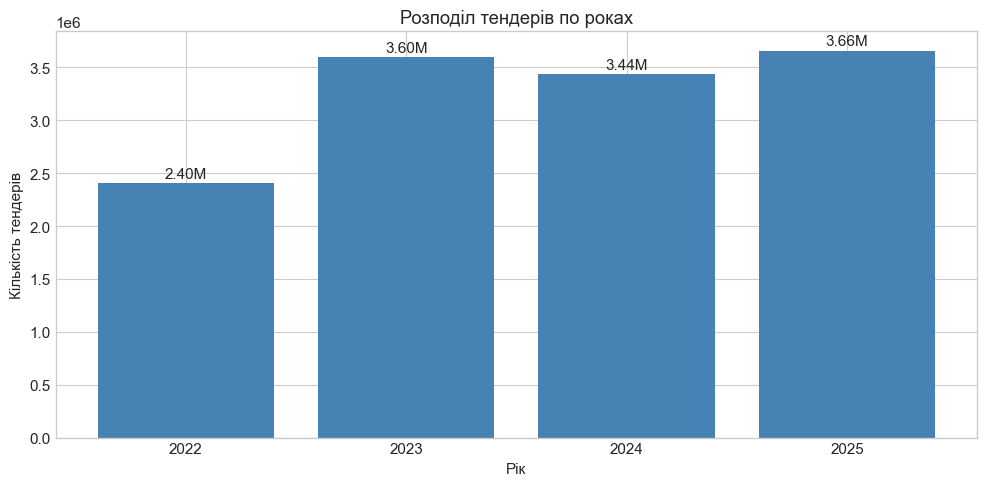

In [6]:
# Tenders by year
year_counts = tenders['year'].value_counts().sort_index()

fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(year_counts.index.astype(str), year_counts.values, color='steelblue')
ax.set_xlabel('Рік')
ax.set_ylabel('Кількість тендерів')
ax.set_title('Розподіл тендерів по роках')

for bar, val in zip(bars, year_counts.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50000, 
            f'{val/1e6:.2f}M', ha='center', fontsize=11)

plt.tight_layout()
plt.show()

C:\Users\kachm\AppData\Local\Temp\ipykernel_7788\928901804.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  tenders['year_month'] = tenders['published_date'].dt.to_period('M')


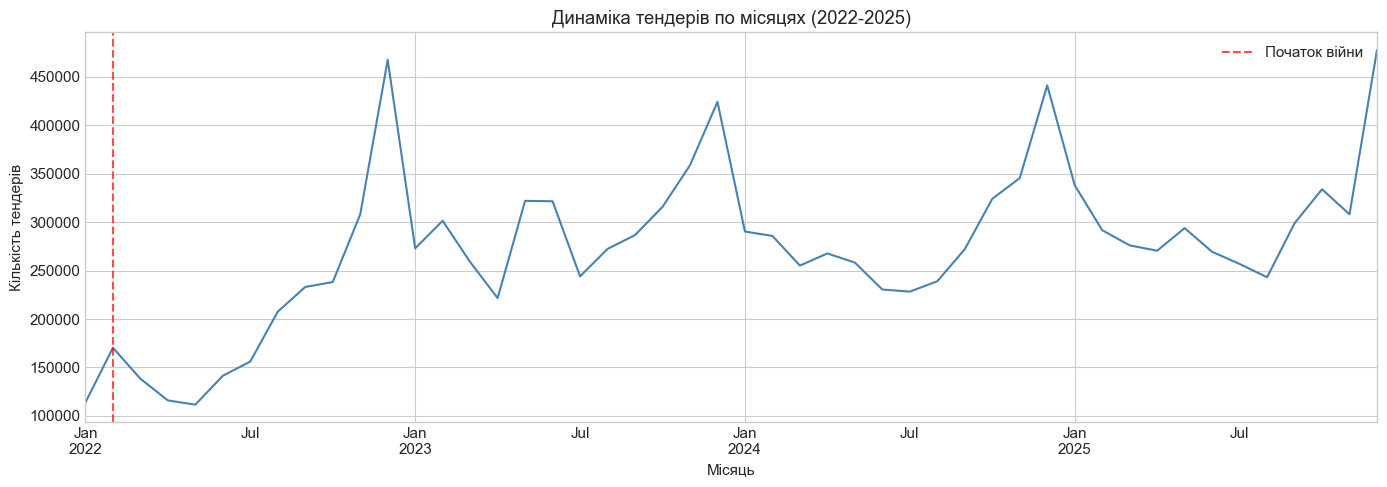

In [7]:
# Tenders by month (all years)
tenders['year_month'] = tenders['published_date'].dt.to_period('M')
monthly = tenders.groupby('year_month').size()

fig, ax = plt.subplots(figsize=(14, 5))
monthly.plot(ax=ax, color='steelblue', linewidth=1.5)
ax.set_xlabel('Місяць')
ax.set_ylabel('Кількість тендерів')
ax.set_title('Динаміка тендерів по місяцях (2022-2025)')
ax.axvline(x=pd.Period('2022-02', 'M'), color='red', linestyle='--', alpha=0.7, label='Початок війни')
ax.legend()
plt.tight_layout()
plt.show()

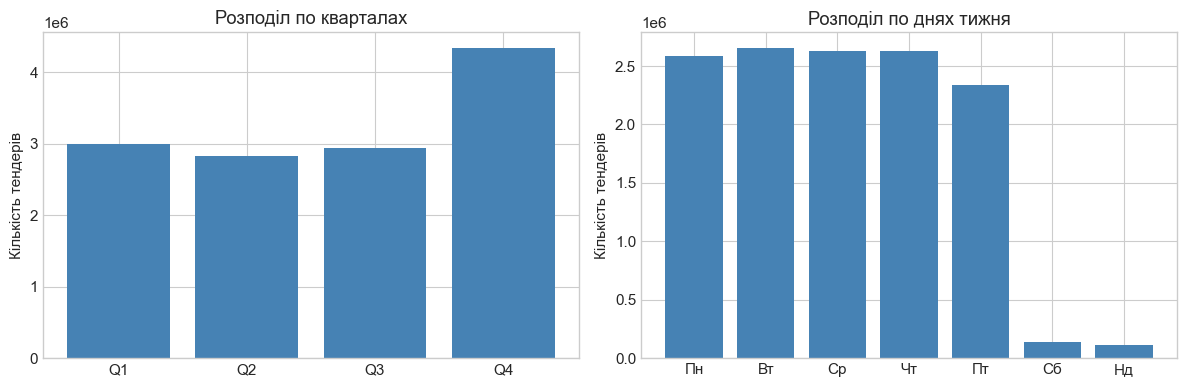

Тендери у вихідні: 1.92%


In [8]:
# Seasonality - by quarter
quarter_counts = tenders['quarter'].value_counts().sort_index()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Quarter distribution
axes[0].bar(['Q1', 'Q2', 'Q3', 'Q4'], quarter_counts.values, color='steelblue')
axes[0].set_title('Розподіл по кварталах')
axes[0].set_ylabel('Кількість тендерів')

# Day of week distribution
dow_counts = tenders['day_of_week'].value_counts().sort_index()
days = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Нд']
axes[1].bar(days, dow_counts.values, color='steelblue')
axes[1].set_title('Розподіл по днях тижня')
axes[1].set_ylabel('Кількість тендерів')

plt.tight_layout()
plt.show()

# Weekend percentage
weekend_pct = tenders['is_weekend'].mean() * 100
print(f'Тендери у вихідні: {weekend_pct:.2f}%')

In [9]:
# Q4 and December effect (budget spending)
q4_rate = tenders['is_q4'].mean() * 100
december_rate = tenders['is_december'].mean() * 100

print(f'Q4 тендери: {q4_rate:.1f}% (очікувано: 25%)')
print(f'Грудень: {december_rate:.1f}% (очікувано: 8.3%)')

# Q4 by year
q4_by_year = tenders.groupby('year')['is_q4'].mean() * 100
print('\nQ4 rate по роках:')
print(q4_by_year)

Q4 тендери: 33.2% (очікувано: 25%)
Грудень: 13.8% (очікувано: 8.3%)

Q4 rate по роках:
year
2022   42.19
2023   30.52
2024   32.31
2025   30.61
Name: is_q4, dtype: float64


## 3. Geographic Analysis

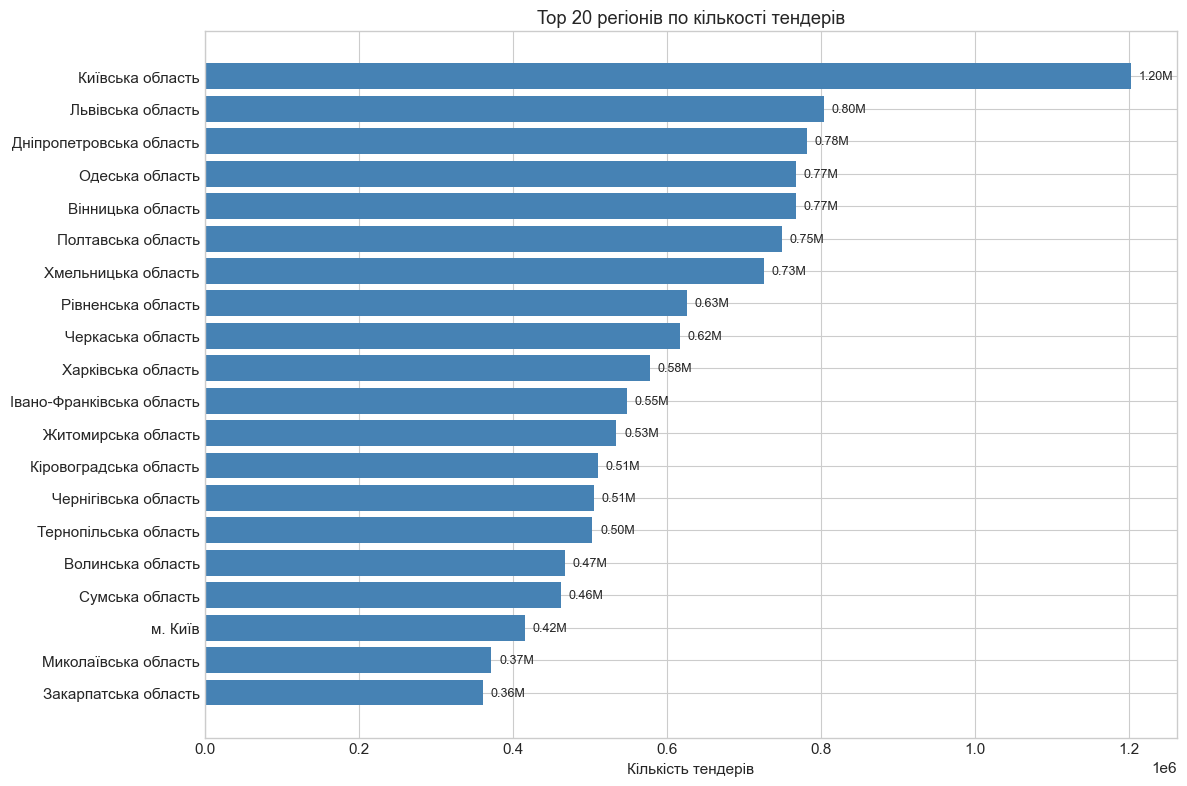

In [10]:
# Top regions by tender count
region_counts = buyers.groupby('buyer_region')['total_tenders'].sum().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(12, 8))
top_regions = region_counts.head(20)
bars = ax.barh(range(len(top_regions)), top_regions.values, color='steelblue')
ax.set_yticks(range(len(top_regions)))
ax.set_yticklabels(top_regions.index)
ax.invert_yaxis()
ax.set_xlabel('Кількість тендерів')
ax.set_title('Top 20 регіонів по кількості тендерів')

for i, val in enumerate(top_regions.values):
    ax.text(val + 10000, i, f'{val/1e6:.2f}M', va='center', fontsize=9)

plt.tight_layout()
plt.show()

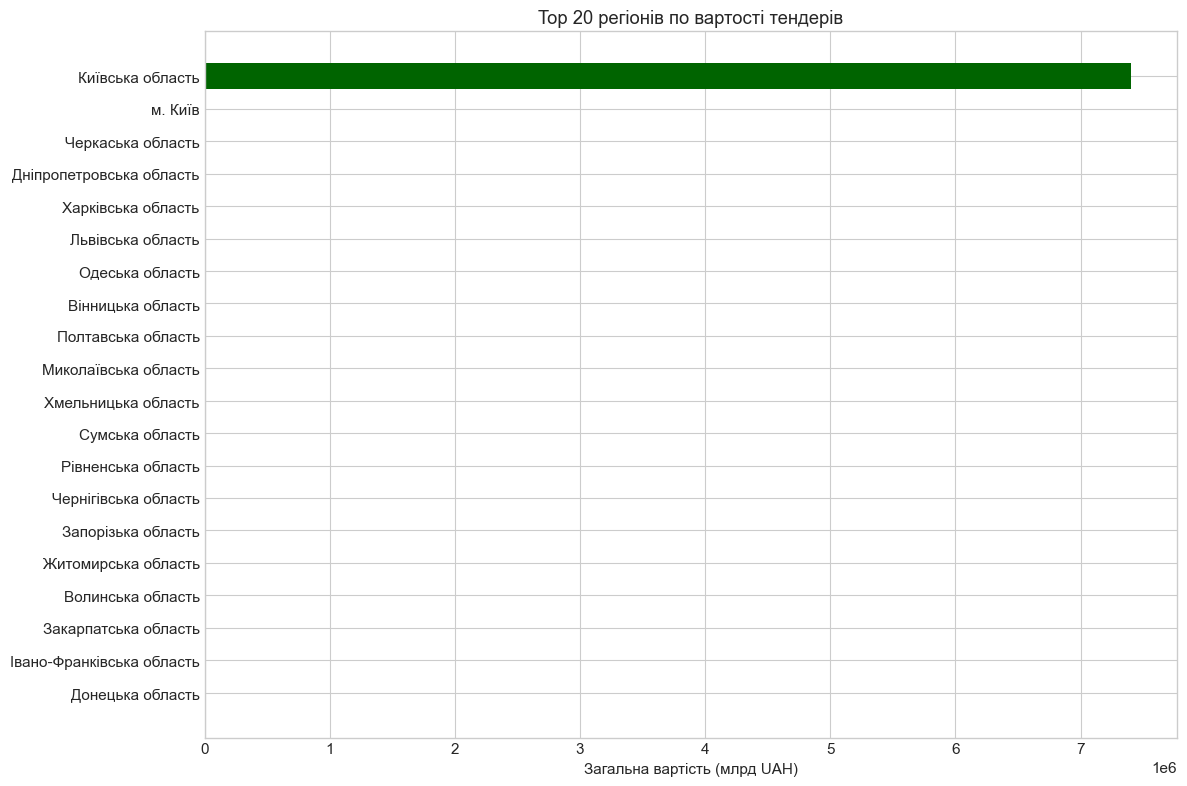

In [11]:
# Top regions by total value
region_values = buyers.groupby('buyer_region')['total_value'].sum().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(12, 8))
top_value_regions = region_values.head(20)
ax.barh(range(len(top_value_regions)), top_value_regions.values / 1e9, color='darkgreen')
ax.set_yticks(range(len(top_value_regions)))
ax.set_yticklabels(top_value_regions.index)
ax.invert_yaxis()
ax.set_xlabel('Загальна вартість (млрд UAH)')
ax.set_title('Top 20 регіонів по вартості тендерів')
plt.tight_layout()
plt.show()

In [12]:
# Cross-region tenders
cross_region_rate = tenders['is_cross_region'].mean() * 100
print(f'Міжрегіональні тендери: {cross_region_rate:.1f}%')

# Cross-region by year
cross_by_year = tenders.groupby('year')['is_cross_region'].mean() * 100
print('\nМіжрегіональність по роках:')
print(cross_by_year)

Міжрегіональні тендери: 4.3%

Міжрегіональність по роках:
year
2022   2.39
2023   3.49
2024   5.05
2025   5.74
Name: is_cross_region, dtype: float64


## 4. Competition Analysis

In [13]:
# Overall competition metrics
competitive_rate = tenders['is_competitive'].mean() * 100
single_bidder_rate = tenders['is_single_bidder'].mean() * 100

print(f'Конкурентні тендери (>1 учасник): {competitive_rate:.1f}%')
print(f'Тендери з одним учасником: {single_bidder_rate:.1f}%')
print(f'\nСередня кількість учасників: {tenders["number_of_tenderers"].mean():.2f}')

Конкурентні тендери (>1 учасник): 4.4%
Тендери з одним учасником: 4.5%

Середня кількість учасників: 0.20


In [14]:
# Competition by year
competition_by_year = tenders.groupby('year').agg({
    'is_competitive': 'mean',
    'is_single_bidder': 'mean',
    'number_of_tenderers': 'mean'
}) * 100
competition_by_year.columns = ['Competitive %', 'Single Bidder %', 'Avg Tenderers']
competition_by_year['Avg Tenderers'] /= 100  # Undo the *100

print('Конкуренція по роках:')
print(competition_by_year)

Конкуренція по роках:
      Competitive %  Single Bidder %  Avg Tenderers
year                                               
2022           2.67             2.66           0.11
2023           2.88             3.86           0.14
2024           5.18             5.15           0.25
2025           6.15             5.81           0.29


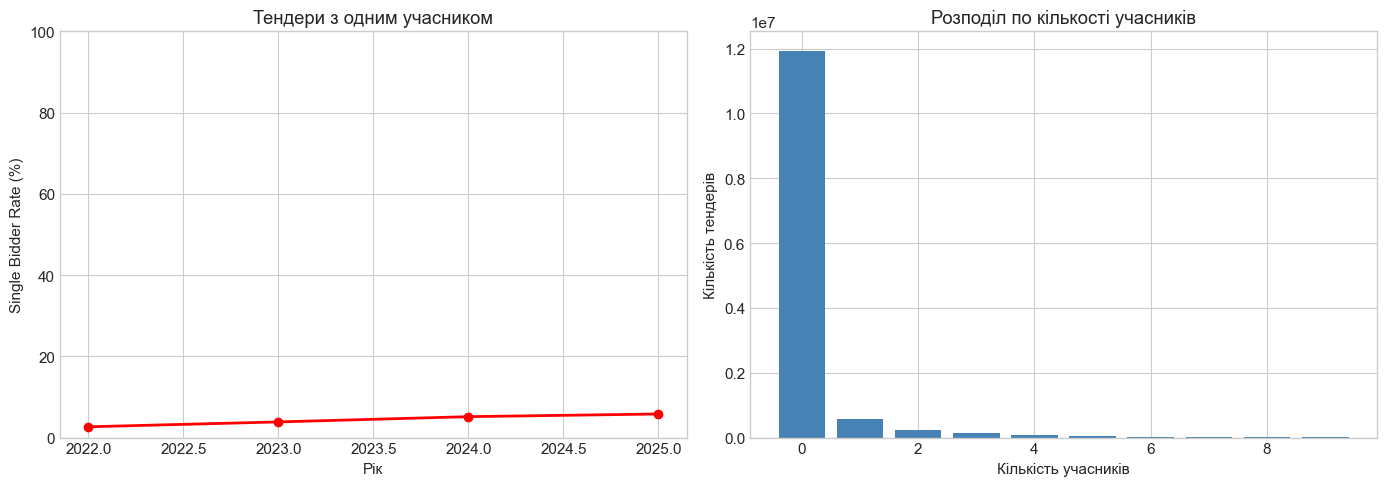

In [15]:
# Competition trends
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Single bidder rate by year
single_by_year = tenders.groupby('year')['is_single_bidder'].mean() * 100
axes[0].plot(single_by_year.index, single_by_year.values, marker='o', linewidth=2, color='red')
axes[0].set_xlabel('Рік')
axes[0].set_ylabel('Single Bidder Rate (%)')
axes[0].set_title('Тендери з одним учасником')
axes[0].set_ylim(0, 100)

# Distribution of number of tenderers
tenderers_dist = tenders['number_of_tenderers'].value_counts().sort_index().head(10)
axes[1].bar(tenderers_dist.index, tenderers_dist.values, color='steelblue')
axes[1].set_xlabel('Кількість учасників')
axes[1].set_ylabel('Кількість тендерів')
axes[1].set_title('Розподіл по кількості учасників')

plt.tight_layout()
plt.show()

In [16]:
# Buyers with highest single bidder rate
suspicious_buyers = buyers[buyers['total_tenders'] >= 100].copy()
suspicious_buyers = suspicious_buyers.sort_values('single_bidder_rate', ascending=False)

print('Top 10 buyers з найвищим single bidder rate (мін. 100 тендерів):')
print(suspicious_buyers[['buyer_name', 'buyer_region', 'total_tenders', 'single_bidder_rate', 'competitive_rate']].head(10).to_string())

Top 10 buyers з найвищим single bidder rate (мін. 100 тендерів):
                                                                                                                          buyer_name              buyer_region  total_tenders  single_bidder_rate  competitive_rate
15365                                                                                     Обласний науково-методичний центр культури         Волинська область            178                1.00              0.00
18859                                                               КОМУНАЛЬНЕ ПІДПРИЄМСТВО КАЛИНІВСЬКОЇ СЕЛИЩНОЇ РАДИ "БЛАГОУСТРІЙ"          Київська область            109                1.00              0.00
10889                                                         Комунальне унітарне підприємство "Комунальник" Вижницької міської ради       Чернівецька область            317                1.00              0.00
18553                                                                              Козе

## 5. Price Analysis

In [17]:
# Tender value distribution
print('Статистика tender_value (UAH):')
print(tenders['tender_value'].describe())

# Filter extreme values for visualization
tender_values = tenders[tenders['tender_value'] > 0]['tender_value']
print(f'\nMedian: {tender_values.median():,.0f} UAH')
print(f'Mean: {tender_values.mean():,.0f} UAH')

Статистика tender_value (UAH):
count      12889355.00
mean         296285.75
std        40648947.70
min               0.01
25%            1200.00
50%            5000.00
75%           26505.55
max     51900000000.00
Name: tender_value, dtype: float64

Median: 5,000 UAH
Mean: 296,286 UAH


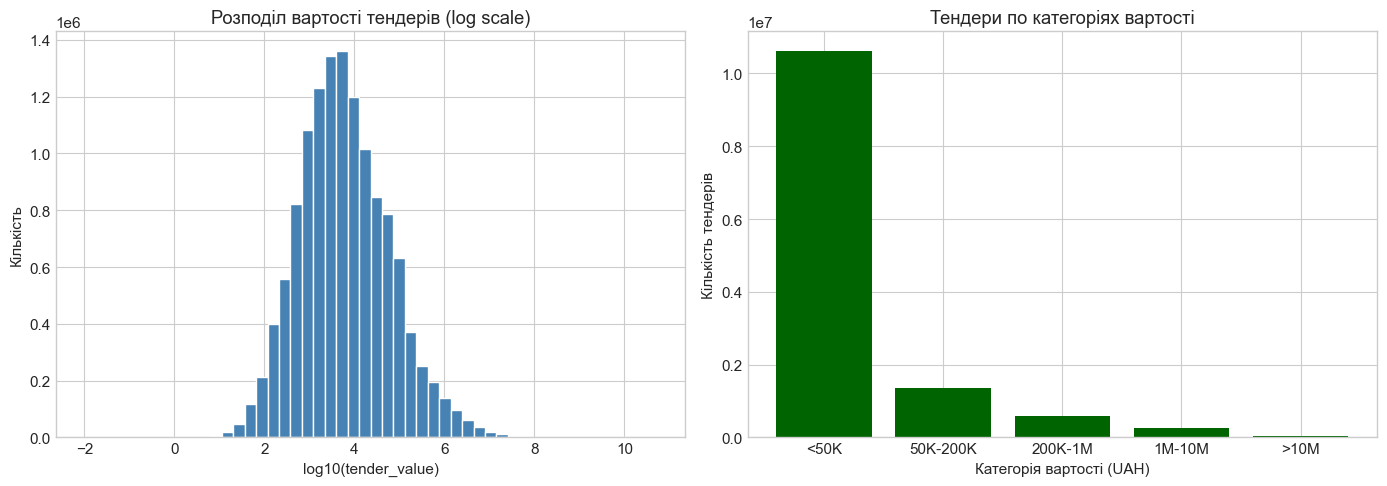

In [18]:
# Value distribution (log scale)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Log distribution
log_values = np.log10(tender_values[tender_values > 0])
axes[0].hist(log_values, bins=50, color='steelblue', edgecolor='white')
axes[0].set_xlabel('log10(tender_value)')
axes[0].set_ylabel('Кількість')
axes[0].set_title('Розподіл вартості тендерів (log scale)')

# Value categories
def categorize_value(val):
    if val < 50000:
        return '<50K'
    elif val < 200000:
        return '50K-200K'
    elif val < 1000000:
        return '200K-1M'
    elif val < 10000000:
        return '1M-10M'
    else:
        return '>10M'

value_cats = tender_values.apply(categorize_value).value_counts()
order = ['<50K', '50K-200K', '200K-1M', '1M-10M', '>10M']
value_cats = value_cats.reindex(order)

axes[1].bar(value_cats.index, value_cats.values, color='darkgreen')
axes[1].set_xlabel('Категорія вартості (UAH)')
axes[1].set_ylabel('Кількість тендерів')
axes[1].set_title('Тендери по категоріях вартості')

plt.tight_layout()
plt.show()

In [19]:
# Price change analysis (discount/markup)
valid_prices = tenders[(tenders['tender_value'] > 0) & (tenders['award_value'] > 0)].copy()
print(f'Тендери з валідними цінами: {len(valid_prices):,} ({len(valid_prices)/len(tenders)*100:.1f}%)')

print('\nСтатистика price_change_pct:')
print(valid_prices['price_change_pct'].describe())

Тендери з валідними цінами: 12,889,355 (98.4%)

Статистика price_change_pct:
count        12889355.00
mean           -12185.44
std          43314963.28
min     -155506320860.38
25%                 0.00
50%                 0.00
75%                 0.00
max               100.00
Name: price_change_pct, dtype: float64


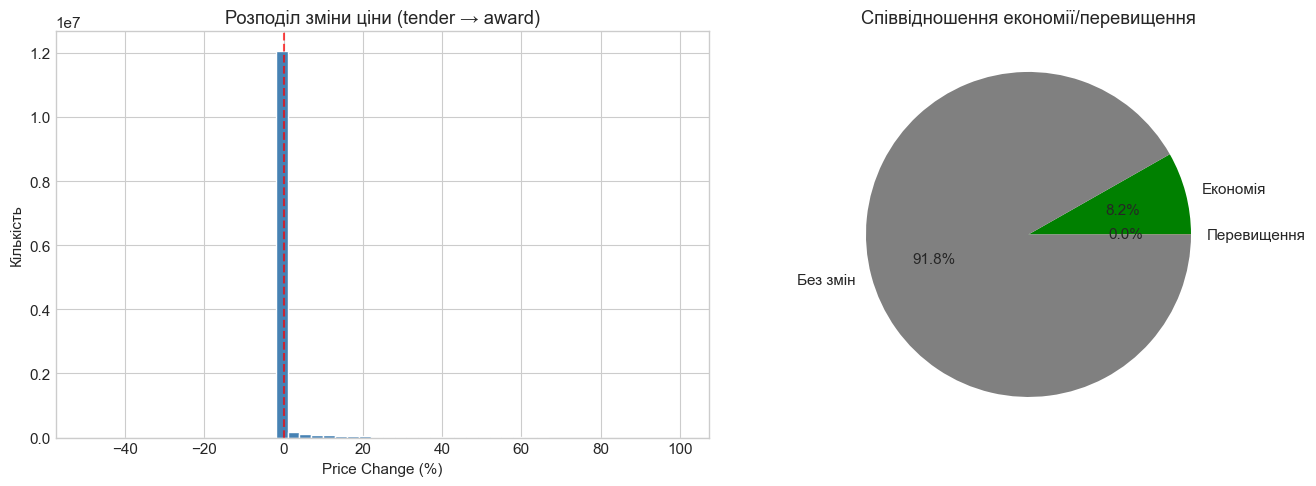

Середня економія: 13.00%
Середнє перевищення: -148045513.10%


In [20]:
# Price change distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of price change
price_change = valid_prices['price_change_pct']
price_change_clipped = price_change.clip(-50, 100)  # Clip for visualization

axes[0].hist(price_change_clipped, bins=50, color='steelblue', edgecolor='white')
axes[0].axvline(x=0, color='red', linestyle='--', alpha=0.7)
axes[0].set_xlabel('Price Change (%)')
axes[0].set_ylabel('Кількість')
axes[0].set_title('Розподіл зміни ціни (tender → award)')

# Savings vs overpayment
savings = (price_change > 0).sum()
overpay = (price_change < 0).sum()
no_change = (price_change == 0).sum()

axes[1].pie([savings, no_change, overpay], 
            labels=['Економія', 'Без змін', 'Перевищення'],
            colors=['green', 'gray', 'red'],
            autopct='%1.1f%%')
axes[1].set_title('Співвідношення економії/перевищення')

plt.tight_layout()
plt.show()

print(f'Середня економія: {price_change[price_change > 0].mean():.2f}%')
print(f'Середнє перевищення: {price_change[price_change < 0].mean():.2f}%')

In [21]:
# Extreme price changes (potential anomalies)
extreme_discount = valid_prices[valid_prices['price_change_pct'] > 50]
extreme_overpay = valid_prices[valid_prices['price_change_pct'] < -20]

print(f'Екстремальна економія (>50%): {len(extreme_discount):,} ({len(extreme_discount)/len(valid_prices)*100:.2f}%)')
print(f'Екстремальне перевищення (<-20%): {len(extreme_overpay):,} ({len(extreme_overpay)/len(valid_prices)*100:.2f}%)')

Екстремальна економія (>50%): 42,187 (0.33%)
Екстремальне перевищення (<-20%): 427 (0.00%)


## 6. Fraud Indicators

In [22]:
# Summary of fraud indicators
print('=== FRAUD INDICATORS SUMMARY ===')
print()

# 1. Single bidder
single_bidder = tenders['is_single_bidder'].sum()
print(f'1. Single Bidder Tenders: {single_bidder:,} ({tenders["is_single_bidder"].mean()*100:.1f}%)')

# 2. Masked data
masked_buyer = tenders['is_buyer_masked'].sum()
masked_supplier = tenders['is_supplier_masked'].sum()
print(f'2. Masked Buyers: {masked_buyer:,} ({tenders["is_buyer_masked"].mean()*100:.2f}%)')
print(f'   Masked Suppliers: {masked_supplier:,} ({tenders["is_supplier_masked"].mean()*100:.2f}%)')

# 3. Weekend tenders
weekend = tenders['is_weekend'].sum()
print(f'3. Weekend Tenders: {weekend:,} ({tenders["is_weekend"].mean()*100:.2f}%)')

# 4. Awards with issues
unsuccessful = tenders['has_unsuccessful_awards'].sum()
cancelled = tenders['has_cancelled_awards'].sum()
print(f'4. Unsuccessful Awards: {unsuccessful:,} ({tenders["has_unsuccessful_awards"].mean()*100:.2f}%)')
print(f'   Cancelled Awards: {cancelled:,} ({tenders["has_cancelled_awards"].mean()*100:.2f}%)')

=== FRAUD INDICATORS SUMMARY ===

1. Single Bidder Tenders: 591,963 (4.5%)
2. Masked Buyers: 13,476 (0.10%)
   Masked Suppliers: 28,298 (0.22%)
3. Weekend Tenders: 251,306 (1.92%)
4. Unsuccessful Awards: 130,599 (1.00%)
   Cancelled Awards: 61,206 (0.47%)


In [23]:
# Bidders with disqualifications
disqualified_bidders = bidders[bidders['disqualified_bids_count'] > 0]
print(f'Bidders з дискваліфікаціями: {len(disqualified_bidders):,} ({len(disqualified_bidders)/len(bidders)*100:.1f}%)')

# Top disqualified bidders
top_disqualified = bidders.nlargest(10, 'disqualified_bids_count')[['bidder_id', 'total_bids', 'disqualified_bids_count']]
top_disqualified['disqualification_rate'] = top_disqualified['disqualified_bids_count'] / top_disqualified['total_bids'] * 100
print('\nTop 10 bidders по кількості дискваліфікацій:')
print(top_disqualified.to_string())

Bidders з дискваліфікаціями: 0 (0.0%)

Top 10 bidders по кількості дискваліфікацій:
                          bidder_id  total_bids  disqualified_bids_count  disqualification_rate
0  0000057e17f5420dba770139aa467b82           1                        0                   0.00
1  aaa7b7f29f594f69be7d6e0a34ed26f7           1                        0                   0.00
2  aaaa98e6d7ed433196018c9bcb907c2d           1                        0                   0.00
3  aaaa9e7504a04db8bbb08c248d9cbf8a           1                        0                   0.00
4  aaaa9ead58534b838a8fbc5d61134276           1                        0                   0.00
5  aaaa9f820bc74d9db09d8488945c6717           1                        0                   0.00
6  aaaaa43f007448ccaba3014b379c76a5           1                        0                   0.00
7  aaaab0948b7f42e49d3e9e73ddf4f3ac           1                        0                   0.00
8  aaaab66d481244159385a013007d00c5           1     

Top 20 suppliers:
  Частка від усіх awards: 6.5%


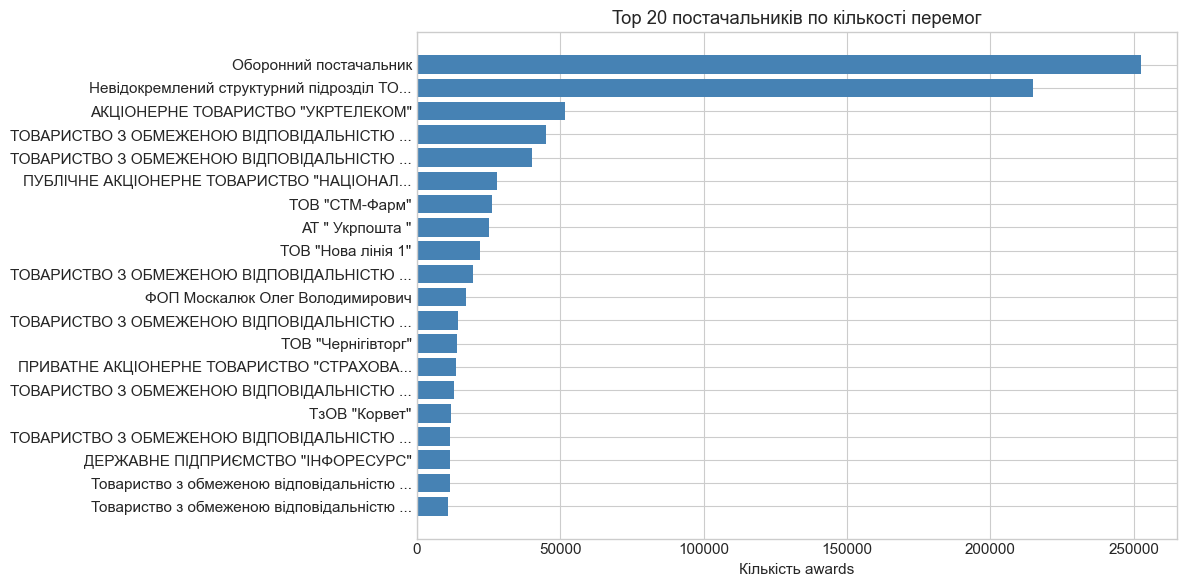

In [24]:
# Supplier concentration (monopolization)
top_suppliers = suppliers.nlargest(20, 'total_awards')
total_awards = suppliers['total_awards'].sum()

print('Top 20 suppliers:')
print(f'  Частка від усіх awards: {top_suppliers["total_awards"].sum() / total_awards * 100:.1f}%')

fig, ax = plt.subplots(figsize=(12, 6))
ax.barh(range(len(top_suppliers)), top_suppliers['total_awards'].values, color='steelblue')
ax.set_yticks(range(len(top_suppliers)))
ax.set_yticklabels([f"{name[:40]}..." if len(str(name)) > 40 else str(name) for name in top_suppliers['supplier_name']])
ax.invert_yaxis()
ax.set_xlabel('Кількість awards')
ax.set_title('Top 20 постачальників по кількості перемог')
plt.tight_layout()
plt.show()

In [25]:
# Buyer-supplier relationships (potential collusion)
# Look at buyers who always use the same supplier
buyer_supplier_diversity = buyers[buyers['total_tenders'] >= 10].copy()
buyer_supplier_diversity = buyer_supplier_diversity.sort_values('supplier_diversity_index')

low_diversity = buyer_supplier_diversity[buyer_supplier_diversity['supplier_diversity_index'] < 0.1]
print(f'Buyers з низькою диверсифікацією постачальників (<10%): {len(low_diversity):,}')

print('\nПриклади (мін. 10 тендерів, диверсифікація < 10%):')
print(low_diversity[['buyer_name', 'total_tenders', 'unique_suppliers', 'supplier_diversity_index']].head(10).to_string())

Buyers з низькою диверсифікацією постачальників (<10%): 9,603

Приклади (мін. 10 тендерів, диверсифікація < 10%):
                                                                                                        buyer_name  total_tenders  unique_suppliers  supplier_diversity_index
15157                Інститут біоорганічної хімії та нафтохімії ім. В.П. Кухаря Національної академії наук України            183              0.00                      0.00
14705                                                                  ДНЗ БЕРЕЗІВСЬКИЙ ПРОФЕСІЙНИЙ АГРАРНИЙ ЛІЦЕЙ            195              0.00                      0.00
14706  Управління соціального захисту населення Хмельницької районної державної адміністрації Хмельницької області            195              0.00                      0.00
14712                                           Фінансове управління Ніжинської міської ради Чернігівської області            194              0.00                      0.00
14727           

In [26]:
# Composite fraud score (simple)
# Higher score = more suspicious
tenders_scored = tenders.copy()

tenders_scored['fraud_score'] = (
    tenders_scored['is_single_bidder'] * 2 +  # Weight: 2
    tenders_scored['is_weekend'] * 1 +         # Weight: 1
    tenders_scored['is_buyer_masked'] * 1 +    # Weight: 1
    tenders_scored['is_supplier_masked'] * 1 + # Weight: 1
    (tenders_scored['price_change_pct'] < -20).astype(int) * 2  # Overpayment
)

print('Розподіл fraud_score:')
print(tenders_scored['fraud_score'].value_counts().sort_index())

# High risk tenders
high_risk = tenders_scored[tenders_scored['fraud_score'] >= 4]
print(f'\nHigh risk тендери (score >= 4): {len(high_risk):,} ({len(high_risk)/len(tenders)*100:.2f}%)')

Розподіл fraud_score:
fraud_score
0    12244319
1      245443
2      588348
3       17865
4          54
5         382
Name: count, dtype: int64

High risk тендери (score >= 4): 436 (0.00%)


## 7. CPV Analysis (Categories)

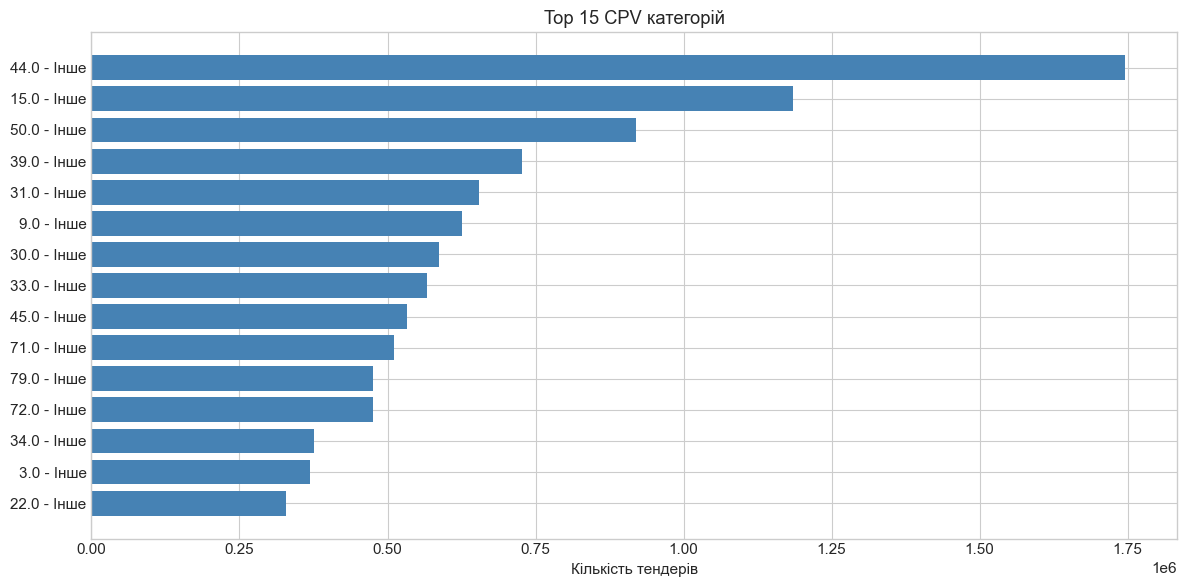

In [27]:
# Top CPV categories (2-digit)
cpv_counts = tenders['main_cpv_2_digit'].value_counts().head(15)

# CPV descriptions (common codes)
cpv_names = {
    '33': 'Медичне обладнання',
    '45': 'Будівництво',
    '09': 'Паливо та енергія',
    '34': 'Транспорт',
    '15': 'Продукти харчування',
    '50': 'Ремонт та обслуговування',
    '44': 'Будматеріали',
    '90': 'Послуги з відходів',
    '72': 'IT послуги',
    '30': 'Офісна техніка',
    '39': 'Меблі',
    '85': 'Охорона здоров\'я',
    '79': 'Бізнес послуги',
    '55': 'Готельні послуги',
    '60': 'Транспортні послуги'
}

fig, ax = plt.subplots(figsize=(12, 6))
labels = [f"{code} - {cpv_names.get(code, 'Інше')}" for code in cpv_counts.index]
ax.barh(range(len(cpv_counts)), cpv_counts.values, color='steelblue')
ax.set_yticks(range(len(cpv_counts)))
ax.set_yticklabels(labels)
ax.invert_yaxis()
ax.set_xlabel('Кількість тендерів')
ax.set_title('Top 15 CPV категорій')
plt.tight_layout()
plt.show()

In [28]:
# Competition by CPV category
cpv_competition = tenders.groupby('main_cpv_2_digit').agg({
    'is_single_bidder': 'mean',
    'tender_id': 'count'
}).rename(columns={'tender_id': 'count', 'is_single_bidder': 'single_bidder_rate'})

cpv_competition = cpv_competition[cpv_competition['count'] >= 10000]  # Min 10K tenders
cpv_competition = cpv_competition.sort_values('single_bidder_rate', ascending=False)

print('CPV категорії з найвищим single bidder rate (мін. 10K тендерів):')
cpv_competition['single_bidder_rate'] = cpv_competition['single_bidder_rate'] * 100
print(cpv_competition.head(10).to_string())

CPV категорії з найвищим single bidder rate (мін. 10K тендерів):
                  single_bidder_rate   count
main_cpv_2_digit                            
33.00                          18.04  566755
55.00                          15.84   41671
45.00                          12.31  532573
38.00                           9.67  105232
3.00                            8.97  369226
9.00                            8.96  625255
77.00                           8.91   36868
32.00                           7.77  142630
35.00                           7.57   80100
48.00                           7.15   72695


## 8. Summary Statistics

In [29]:
# Final summary
print('='*60)
print('PROZORRO DATASET SUMMARY')
print('='*60)
print(f'\nTotal tenders: {len(tenders):,}')
print(f'Total buyers: {len(buyers):,}')
print(f'Total suppliers: {len(suppliers):,}')
print(f'Total bidders: {len(bidders):,}')
print(f'\nDate range: {tenders["year"].min()} - {tenders["year"].max()}')
print(f'Total value: {tenders["tender_value"].sum() / 1e12:.2f} trillion UAH')
print(f'\n--- Competition ---')
print(f'Competitive rate: {tenders["is_competitive"].mean()*100:.1f}%')
print(f'Single bidder rate: {tenders["is_single_bidder"].mean()*100:.1f}%')
print(f'Avg tenderers: {tenders["number_of_tenderers"].mean():.2f}')
print(f'\n--- Price ---')
print(f'Median tender value: {tenders["tender_value"].median():,.0f} UAH')
print(f'Avg price change: {tenders["price_change_pct"].mean():.2f}%')
print(f'\n--- Data Quality ---')
print(f'Masked buyers: {tenders["is_buyer_masked"].mean()*100:.2f}%')
print(f'Masked suppliers: {tenders["is_supplier_masked"].mean()*100:.2f}%')
print('='*60)

PROZORRO DATASET SUMMARY

Total tenders: 13,096,411
Total buyers: 36,004
Total suppliers: 358,983
Total bidders: 2,629,571

Date range: 2022 - 2025
Total value: 3.82 trillion UAH

--- Competition ---
Competitive rate: 4.4%
Single bidder rate: 4.5%
Avg tenderers: 0.20

--- Price ---
Median tender value: 5,000 UAH
Avg price change: -11992.79%

--- Data Quality ---
Masked buyers: 0.10%
Masked suppliers: 0.22%


In [30]:
# Save key statistics for thesis
stats = {
    'total_tenders': len(tenders),
    'total_buyers': len(buyers),
    'total_suppliers': len(suppliers),
    'total_bidders': len(bidders),
    'total_value_trillion_uah': tenders['tender_value'].sum() / 1e12,
    'competitive_rate': tenders['is_competitive'].mean() * 100,
    'single_bidder_rate': tenders['is_single_bidder'].mean() * 100,
    'avg_tenderers': tenders['number_of_tenderers'].mean(),
    'median_tender_value': tenders['tender_value'].median(),
    'avg_price_change_pct': tenders['price_change_pct'].mean(),
}

stats_df = pd.DataFrame([stats])
stats_df.to_csv('eda_summary_stats.csv', index=False)
print('Statistics saved to eda_summary_stats.csv')

Statistics saved to eda_summary_stats.csv
